# pyPCGA tutorial example - permeability estimation using tracer travel time using CrunchTope

## Problem description 

+ Assume that an isotope tracer test is performed on a 2D (depth-integrated) confined aquifer and surface electrical resistivity survey could tell when the tracer reaches every location of the aquifer. 

+ Because of nonunique petrophysical relationship, we assume to only get reasonable mean tracer arrival time measurements (the first normalized moment of BTC m1/m0). 

+ isotope tracer transport is simulated by [CrunchTope](https://bitbucket.org/crunchflow/crunchtope/downloads/) (advection-diffusion equation). Forward problem was prepared by Mahta Ansari and Jenny Druhan. 

+ The domain size is **5 m by 5 m** (with 50 by 50 discretization grids) and regional groundwater flow from left to right

### Assuming we know all the aquifer conditions, can we reconstruct permeability field with tracer travel time measurements? 

To reproduce this experiment, you have to install [CrunchTope](https://bitbucket.org/crunchflow/crunchtope/downloads/) and copy the CrunchTope executable in the directory ./input_files 

For more information on CrunchTope and reactive transport modeling, please visit [PSU PNG550/CE574 Lecture page](https://www.e-education.psu.edu/png550/node/829) taught by Li Li. 

In [1]:
%matplotlib inline

+ Test environment 

In [2]:
import sys
print(sys.version)

2.7.12 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [3]:
import platform
print(platform.platform()) # ubuntu

Linux-4.4.0-134-generic-x86_64-with-debian-stretch-sid


In [4]:
import numpy as np
print(np.__version__)

1.9.3


In [5]:
import psutil
print('# of physcial CPU cores %s' % (psutil.cpu_count(logical=False)))

# of physcial CPU cores 36


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import crunch
from pyPCGA import PCGA
import math

+ model domain/discretization, forward model parameters

In [7]:
nx = ny = 50
# BTC observation record time for travel time computation
t = np.array([1.1574E-05, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,\
0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0])


+ load true log permeability field lnk

<matplotlib.colorbar.Colorbar instance at 0x7fb2a8f640e0>

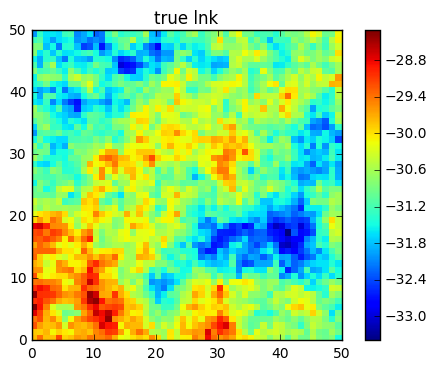

In [8]:
s_true = np.loadtxt('true.txt')
plt.pcolormesh(s_true.reshape(ny,nx))
plt.title('true lnk')
plt.gca().set_aspect('equal','box')
plt.colorbar()

+ simulated concentration profile for illustration

<matplotlib.colorbar.Colorbar instance at 0x7fb2a8c2afc8>

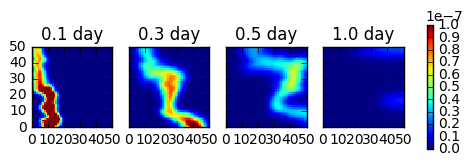

In [9]:
cobs = np.loadtxt('cobs.txt') # simulated tracer concentration with s_true

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(nrows=1,ncols=4, sharey = True)

vmax = 1.e-7
im0 = ax[0].pcolormesh(cobs[:,2].reshape(ny,nx),vmin=0.,vmax=vmax)
ax[0].set_title('%3.1f day' % (t[2]))
ax[0].set_aspect('equal','box-forced')

im1 = ax[1].pcolormesh(cobs[:,4].reshape(ny,nx),vmin=0.,vmax=vmax)
ax[1].set_title('%3.1f day' % (t[4]))
ax[1].set_aspect('equal','box-forced')

im2 = ax[2].pcolormesh(cobs[:,6].reshape(ny,nx),vmin=0.,vmax=vmax)
ax[2].set_title('%3.1f day' % (t[6]))
ax[2].set_aspect('equal','box-forced')

im3 =ax[3].pcolormesh(cobs[:,11].reshape(ny,nx),vmin=0.,vmax=vmax)
ax[3].set_title('%3.1f day' % (t[11]))
ax[3].set_aspect('equal','box-forced')
fig.colorbar(im0, ax=ax.ravel().tolist(),shrink=0.4)


+ PCGA parameters (m: # of unknowns, N, xmin, xmax: structure grid parameters)

In [10]:
m = nx*ny
N = np.array([nx,ny])
xmin = np.array([0,0])
xmax = np.array([5,5])
pts = None # for regular grids, you don't need to specify pts. 

+ PCGA - prior information parameters

In [11]:
# covairance kernel and scale parameters
prior_std = 0.2
prior_cov_scale = np.array([2.0,2.0])

def kernel(r): return (prior_std ** 2) * np.exp(-r)

+ load noisy travel time measurements

measurements were generated as 

```python
obs = simul_obs + 0.01*np.random.randn(m,1)  # error std = 0.01 day
obs[obs < 0.] = 0.
```
where simul_obs is simulated travel time measurements. 

while Gaussian error model might be reasonable due to the integration of non-Gaussian errors in each tracer concentration, noisy measurements will be updated with more realistic error model (Gaussian noise in concentration)

In [12]:
obs = np.loadtxt('obs.txt')

+ Define a wrapper for a black-box forward model input in pyPCGA

#### 1. Note that one should follow this wrapper format to work with pyPCGA
#### 2. If parallelization == True, it should take multiple columns of s and run the forward problem independently in parallel
#### 3. Please see crunch.py as a template for inplementation

In [13]:
# forward model wrapper for pyPCGA
def forward_model(s, parallelization, ncores=None):
    params = {'nx':nx,'ny':ny,'t':t}
    model = crunch.Model(params)

    if parallelization:
        simul_obs = model.run(s, parallelization, ncores)
    else:
        simul_obs = model.run(s, parallelization)
    return simul_obs

+ PCGA inversion parameters

In [14]:
params = {'R': (0.01) ** 2, 'n_pc': 50,
    'maxiter': 10, 'restol': 0.01,
    'matvec': 'FFT', 'xmin': xmin, 'xmax': xmax, 'N': N,
    'prior_std': prior_std, 'prior_cov_scale': prior_cov_scale,
    'kernel': kernel, 'post_cov': "diag",
    'precond': True, 'LM': True,
    'parallel': True, 'linesearch': True,
    'forward_model_verbose': False, 'verbose': False,
    'iter_save': True}

# params['objeval'] = False, if true, it will compute accurate objective function
# params['ncores'] = 36, with parallell True, it will determine maximum physcial core unless specified


In [15]:
s_init = np.mean(s_true) * np.ones((m, 1)) # any initial guess you can test

## Inversion
+ Initialize pyPCGA

In [16]:
prob = PCGA(forward_model, s_init, pts, params, s_true, obs)

##### PCGA Inversion #####
##### 1. Initialize forward and inversion parameters
------------ Inversion Parameters -------------------------
   Number of unknowns                               : 2500
   Number of observations                           : 2500
   Number of principal components (n_pc)            : 50
   Prior model                                      : def kernel(r): return (prior_std ** 2) * np.exp(-r)

   Prior variance                                   : 4.000000e-02
   Prior scale (correlation) parameter              : [ 2.  2.]
   Posterior cov computation                        : diag
   Posterior variance computation                   : Approx.
   Number of CPU cores (n_core)                     : 36
   Maximum GN iterations                            : 10
   machine precision (delta = sqrt(precision))      : 1.000000e-08
   Tol for iterations (norm(sol_diff)/norm(sol))    : 1.000000e-02
   Levenberg-Marquardt (LM)                         : True
   LM solution rang

+ Run pyPCGA

In [17]:
s_hat, simul_obs, post_diagv, iter_best = prob.Run()

##### 2. Construct Prior Covariance Matrix
- time for covariance matrix construction (m = 2500) is 0 sec
##### 3. Eigendecomposition of Prior Covariance
- time for eigendecomposition with k = 50 is 1 sec
- 1st eigv : 32.8021, 50-th eigv : 0.115767, ratio: 0.00352927
##### 4. Start PCGA Inversion #####
-- evaluate initial solution
obs. RMSE (norm(obs. diff.)/sqrt(nobs)): 0.142941, normalized obs. RMSE (norm(obs. diff./sqrtR)/sqrt(nobs)): 14.2941
***** Iteration 1 ******
computed Jacobian-Matrix products in 110.577213 secs
solve saddle point (co-kriging) systems with Levenberg-Marquardt
evaluate LM solutions
LM solution evaluted
- Geostat. inversion at iteration 1 is 188 sec
== iteration 1 summary ==
= objective function is 2.924042e+04, relative L2-norm diff btw sol 0 and sol 1 is 0.0145561
= L2-norm error (w.r.t truth) is 1.51529, obs. RMSE is 0.0482918, obs. normalized RMSE is 4.82918
- save results in text at iteration 1
***** Iteration 2 ******
computed Jacobian-Matrix products in 1

Results
+ plot the best estimate, posterior std, obs mismatch and objection fuction values over iterations

It has been shown that sparse tracer data alone is not informative enough to estimate underlying permeability field well  [Cirpka and Kitanidis, 2000, Lee and Kitanidis, 2014]. However, as shown below, if we have **lots** of tracer information, we would be able to reconstruct unknown permeability field quite well without pressure measurements. See Lee et al. [2016] for more information

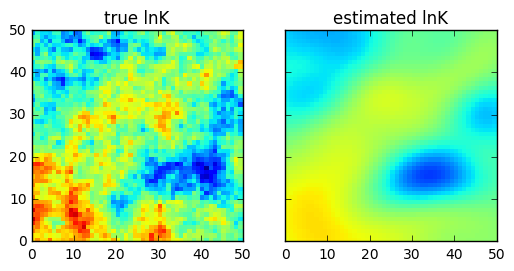

In [18]:
fig, ax = plt.subplots(nrows=1,ncols=2,sharey=True)
ax[0].pcolormesh(s_true.reshape(ny,nx),vmin=-33.5,vmax=-28.0)
ax[0].set_title('true lnK')
ax[0].set_aspect('equal','box-forced')
ax[1].pcolormesh(s_hat.reshape(ny,nx),vmin=-33.5,vmax=-28.0)
ax[1].set_title('estimated lnK')
ax[1].set_aspect('equal','box-forced')


<matplotlib.colorbar.Colorbar instance at 0x7fb2a874a3f8>

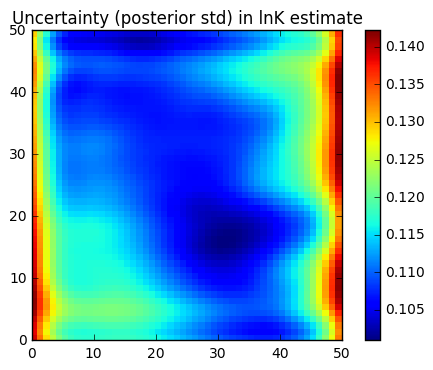

In [19]:
post_std = np.sqrt(post_diagv)

plt.pcolormesh(post_std.reshape(ny,nx))
plt.gca().set_aspect('equal', 'box')
plt.title('Uncertainty (posterior std) in lnK estimate')
plt.colorbar()


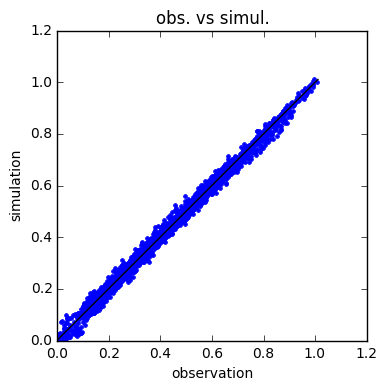

In [20]:
plt.title('obs. vs simul.')
plt.plot(prob.obs, simul_obs, '.')
plt.xlabel('observation')
plt.ylabel('simulation')
minobs = np.vstack((prob.obs, simul_obs)).min(0)
maxobs = np.vstack((prob.obs, simul_obs)).max(0)
plt.plot(np.linspace(0., maxobs, 20), np.linspace(0., maxobs, 20), 'k-')
plt.gca().set_aspect('equal','box')


(1.0, 2.0, 8513.1944158303158, 31252.445001998371)

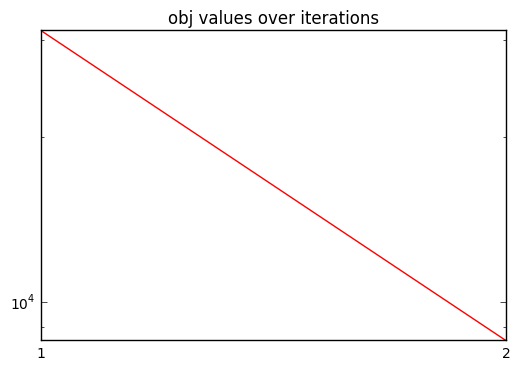

In [21]:
plt.semilogy(np.linspace(1,len(prob.objvals),len(prob.objvals)), prob.objvals, 'r-')
plt.xticks(np.linspace(1,len(prob.objvals),len(prob.objvals)))
plt.title('obj values over iterations')
plt.axis('tight')
